## Bots and Gender Profiling
https://pan.webis.de/clef19/pan19-web/author-profiling.html

### feature engineering

In [59]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelBinarizer

#### unpickling the dataframe

In [65]:
df_train = pd.read_pickle("./pan19_df_clean_train_max.pkl")
df_test = pd.read_pickle("./pan19_df_clean_test_max.pkl")
print(f"train size: {df_train.shape}, test size: {df_test.shape}")

train size: (412000, 4), test size: (264000, 4)


In [66]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top n most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(15,terms / 5))
    ax = sns.barplot(data=d, x= "count", y = "word", color='lightseagreen')
    ax.set(ylabel = 'Word')

    plt.show()
    return words_df.shape[0]

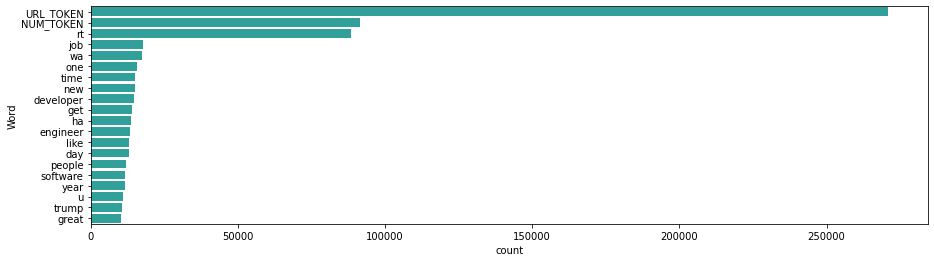

Number of distinct words in dataset: 100168


In [67]:
# print 20 most frequent words, without rt
size = freq_words(df_train['clean_tweet'], 20)
print(f"Number of distinct words in dataset: {size}")

In [68]:
df = df_train.append(df_test)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 676000 entries, 0 to 263999
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   author       676000 non-null  object
 1   tweet        676000 non-null  object
 2   bot          676000 non-null  object
 3   clean_tweet  676000 non-null  object
dtypes: object(4)
memory usage: 25.8+ MB


In [69]:
# df.head()
df['tweet'].sample(n=3, random_state=1)

208373    RT @mikevansickler: Whoa. Sports Authority to ...
361481    RT @EcoAllison: #RiseforClimate event at Trini...
266636    Me irl https://t.co/BlRA1lcID3 https://t.co/lV...
Name: tweet, dtype: object

In [21]:
df_temp = df_train.copy()
df_temp['length'] = df_temp['clean_tweet'].apply(len)
mean = df_temp['length'].mean()
mean


56.998856796116506

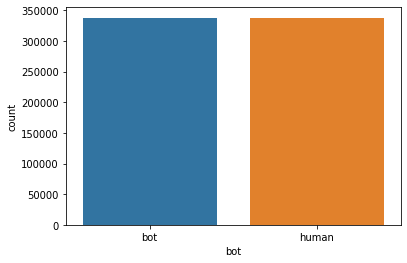

In [22]:
sns.countplot(df['bot'])

In [101]:
def feature(df) :
    df['word_count'] = df['tweet'].apply(lambda x : len(x.split()))
    df['char_count'] = df['tweet'].apply(lambda x : len(x.replace(" ","")))
    df['word_density'] = df['word_count'] / (df['char_count'] + 1)
    df['total_length'] = df['tweet'].apply(len)
    df['capitals'] = df['tweet'].apply(lambda tweet: sum(1 for c in tweet if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['total_length']),axis=1)
    df['num_exclamation_marks'] =df['tweet'].apply(lambda x: x.count('!'))
    df['num_question_marks'] = df['tweet'].apply(lambda x: x.count('?'))
    df['num_punctuation'] = df['tweet'].apply(lambda x: sum(x.count(w) for w in '.,;:'))
    df['num_symbols'] = df['tweet'].apply(lambda x: sum(x.count(w) for w in '*&$%'))
    df['num_unique_words'] = df['tweet'].apply(lambda x: len(set(w for w in x.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['word_count']
    df["word_unique_percent"] =  df["num_unique_words"]*100/df['word_count']
    df['num_retweet'] = df['clean_tweet'].apply(lambda x: x.count('rt'))
    df['num_url'] = df['clean_tweet'].apply(lambda x: x.count('URL_TOKEN'))
    df['num_number'] = df['clean_tweet'].apply(lambda x: x.count('NUM_TOKEN'))
    return df

In [102]:
df = feature(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 676000 entries, 0 to 263999
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   author                 676000 non-null  object 
 1   tweet                  676000 non-null  object 
 2   bot                    676000 non-null  object 
 3   clean_tweet            676000 non-null  object 
 4   word_count             676000 non-null  int64  
 5   char_count             676000 non-null  int64  
 6   word_density           676000 non-null  float64
 7   total_length           676000 non-null  int64  
 8   capitals               676000 non-null  int64  
 9   caps_vs_length         676000 non-null  float64
 10  num_exclamation_marks  676000 non-null  int64  
 11  num_question_marks     676000 non-null  int64  
 12  num_punctuation        676000 non-null  int64  
 13  num_symbols            676000 non-null  int64  
 14  num_unique_words       676000 non-nu

In [103]:
print(df.loc[df["bot"] == "human"]['num_retweet'].mean())
print(df.loc[df["bot"] == "human"]['word_count'].mean())
print(df.loc[df["bot"] == "human"]['num_url'].mean())
print(df.loc[df["bot"] == "human"]['num_number'].mean())

print(df.loc[df["bot"] == "bot"]['num_retweet'].mean())
print(df.loc[df["bot"] == "bot"]['word_count'].mean())
print(df.loc[df["bot"] == "bot"]['num_url'].mean())
print(df.loc[df["bot"] == "bot"]['num_number'].mean())

0.4928786982248521
15.67326923076923
0.4660177514792899
0.18921005917159764
0.28942307692307695
17.092402366863904
0.8753076923076923
0.3868994082840237


In [114]:
import plotly.graph_objects as go

fig = go.Figure(
    data=[
        #         go.Scatterpolar(
        #             r=[df.loc[df["bot"] == "bot"]['total_length'].median(),
        #                 df.loc[df["bot"] == "bot"]['word_count'].median(),
        #                 df.loc[df["bot"] == "bot"]['num_unique_words'].median(),
        #                 df.loc[df["bot"] == "bot"]['num_retweet'].median() * 100,
        #                 df.loc[df["bot"] == "bot"]['char_count'].median()],
        #             theta=['Total_Lenght', 'WordCount',
        #                    'Count_unique_words', "Number of retweets", "Charcount"],
        #             fill='toself',
        #             line=dict(color='brown'),
        #             name="bot stats", subplot="polar"),

        #         go.Scatterpolar(
        #             r=[df.loc[df["bot"] == "human"]['total_length'].median(),
        #                 df.loc[df["bot"] == "human"]['word_count'].median(),
        #                 df.loc[df["bot"] == "human"]['num_unique_words'].median(),
        #                 df.loc[df["bot"] == "human"]['num_retweet'].median() * 100,
        #                 df.loc[df["bot"] == "human"]['char_count'].median()],
        #             theta=['Total_Lenght', 'WordCount',
        #                    'Count_unique_words', "Number of retweets", "Charcount"],
        #             fill='toself',
        #             line=dict(color='magenta'),
        #             name="human stats", subplot="polar2"),
        go.Scatterpolar(
            r=[df.loc[df["bot"] == "bot"]['num_url'].mean() * 100,
               df.loc[df["bot"] == "bot"]['num_number'].mean() * 100,
               df.loc[df["bot"] == "bot"]['num_retweet'].mean() * 100],
            theta=['urls', "nums", "Number of retweets"],
            fill='toself',
            line=dict(color='red'),
            name="bot stats means", subplot="polar3"),

        go.Scatterpolar(
            r=[df.loc[df["bot"] == "human"]['num_url'].mean() * 100,
               df.loc[df["bot"] == "human"]['num_number'].mean() * 100,
               df.loc[df["bot"] == "human"]['num_retweet'].mean() * 100],
            theta=['urls', "nums", "Number of retweets"],
            fill='toself',
            line=dict(color='blue'),
            name="human stats means", subplot="polar3"),

        go.Scatterpolar(
            r=[df.loc[df["bot"] == "bot"]['total_length'].mean(),
                df.loc[df["bot"] == "bot"]['char_count'].mean(),
                df.loc[df["bot"] == "bot"]['word_count'].mean()],
            theta=['Total_Lenght', 'Charcount', "word count"],
            fill='toself',
            line=dict(color='brown'),
            name="bot stats means", subplot="polar3"),

        go.Scatterpolar(
            r=[df.loc[df["bot"] == "human"]['total_length'].mean(),
                df.loc[df["bot"] == "human"]['char_count'].mean(),
                df.loc[df["bot"] == "bot"]['word_count'].mean()],
            theta=['Total_Lenght', 'Charcount', "word count"],
            fill='toself',
            line=dict(color='magenta'),
            name="human stats means", subplot="polar3")
    ],
    layout=go.Layout(
        polar3=dict(
            domain=dict(
                x=[1, 1],
                y=[1, 1]
            ),
            radialaxis=dict(visible=True,)),
        polar2=dict(
            domain=dict(
                x=[0, 0.3],
                y=[0, 0.45]
            ),
            radialaxis=dict(visible=True,)),

        polar=dict(
            domain=dict(
                x=[0.33, 0.6525],
                y=[0, 0.45]
            ),
            radialaxis=dict(visible=True,)),

        polar4=dict(
            domain=dict(
                x=[0.33, 0.6525],
                y=[0.55, 1]
            ),
            radialaxis=dict(visible=True,)),

        polar5=dict(
            domain=dict(
                x=[0.6775, 1],
                y=[0, 0.45]
            ),
            radialaxis=dict(visible=True,)),
        polar6=dict(
            domain=dict(
                x=[0.6775, 1],
                y=[0.55, 1]
            ),
            radialaxis=dict(visible=True,))
    )
)

fig.show()

#### transforming target variables

In [5]:
multilabel_binarizer = LabelBinarizer()
multilabel_binarizer.fit(df_train['bot'])
list(multilabel_binarizer.classes_)

['bot', 'human']

In [6]:
ytrain = multilabel_binarizer.transform(df_train['bot'])
ytest = multilabel_binarizer.transform(df_test['bot'])
print(f"train dimensions: {len(ytrain), len(ytrain[0])}")
print(f"test dimensions: {len(ytest), len(ytest[0])}")

train dimensions: (412000, 1)
test dimensions: (264000, 1)


In [7]:
xtrain=df_train.clean_tweet
xtest=df_test.clean_tweet
print(f"train dimensions: {len(xtrain), len(xtrain[0])}")
print(f"test dimensions: {len(xtest), len(xtest[0])}")

train dimensions: (412000, 118)
test dimensions: (264000, 30)


In [8]:
xtrain[0]

'brief chat hope hick accidentally convinces president trump nazi heavily armed adam sandler get tackled secret service'

In [9]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000, ngram_range = (1,3))

xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xtest_tfidf = tfidf_vectorizer.transform(xtest)
print (xtrain_tfidf.shape, xtest_tfidf.shape)

(412000, 10000) (264000, 10000)


In [16]:
X_train, X_test, y_train, y_test = xtrain_tfidf, xtest_tfidf, ytrain, ytest

print(X_train.shape)
X_train_new = SelectKBest(chi2, k=20).fit_transform(X_train, y_train)
print(X_train_new.shape)
print(type(X_train_new))
print(type(X_train_new.toarray()))
print(X_train_new.toarray().shape)


(412000, 10000)
(412000, 20)
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>
(412000, 20)


In [10]:
from sklearn import svm
# from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print(__doc__)

# import some data to play with
# X, y = make_classification(
#     n_features=20, n_informative=3, n_redundant=0, n_classes=4,
#     n_clusters_per_class=2)

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train, X_test, y_train, y_test = xtrain_tfidf, xtest_tfidf, ytrain, ytest
# ANOVA SVM-C
# 1) anova filter, take 3 best ranked features
anova_filter = SelectKBest(f_regression, k=2000)
# 2) svm
clf = svm.LinearSVC()

anova_svm = make_pipeline(anova_filter, clf)

anova_svm.fit(X_train.toarray(), y_train.ravel())
y_pred = anova_svm.predict(X_test)
print(classification_report(y_test, y_pred))

coef = anova_svm[:-1].inverse_transform(anova_svm['linearsvc'].coef_)
print(coef)

Automatically created module for IPython interactive environment
              precision    recall  f1-score   support

           0       0.80      0.51      0.62    132000
           1       0.64      0.87      0.74    132000

    accuracy                           0.69    264000
   macro avg       0.72      0.69      0.68    264000
weighted avg       0.72      0.69      0.68    264000

[[0. 0. 0. ... 0. 0. 0.]]


#### prediction

In [31]:
# no mentions, hashtags, urls, numbers
print(f"accuracy_score: {accuracy_score(ytest, y_predict_nb)}")
print(f"f1-macro: {f1_score(ytest, y_predict_nb, average='macro')}")

accuracy_score: 0.6536363636363637
f1-macro: 0.6272872259651714
